In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# generate a distribution: a coin flip 
theta = 0.4
coin = pd.DataFrame({'side': ['heads', 'tails'], 'prob': [theta, 1 - theta]})
coin

,side,prob
0,heads,0.4
1,tails,0.6


In [3]:
# sample with replacement 
n = 10
coin.sample(n=n, weights='prob', replace=True)

,side,prob
0,heads,0.4
0,heads,0.4
0,heads,0.4
1,tails,0.6
1,tails,0.6
0,heads,0.4
1,tails,0.6
0,heads,0.4
0,heads,0.4
0,heads,0.4


In [4]:
# estimate theta
# every time we sample from the data, we get a different estimate for theta
coin.sample(n=10, weights='prob', replace=True).groupby('side').size() / n

side
heads    0.3
tails    0.7
dtype: float64

<AxesSubplot:ylabel='Count'>

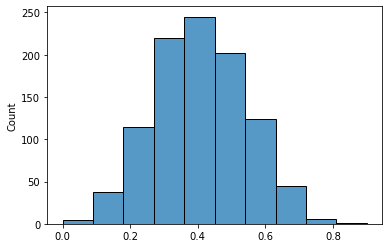

In [5]:
# how would our estimate be different on different samples?
trials = 1000
theta_hats = np.zeros(trials)
for t in range(trials):
    try:
        theta_hats[t] = coin.sample(n=n, weights='prob', replace=True).groupby('side').size()['heads'] / n
    except:
        theta_hats[t] = 0

sns.histplot(theta_hats, bins=10)

In [6]:
# compute the mean and variance of the estimates
theta_hats.mean(), theta_hats.var()

(0.4034, 0.023088440000000002)

In [7]:
# how does this compare to our analytical result?
print("empirical variance:", theta_hats.var())
print("analytical variance:", theta * (1 - theta) / n)

empirical variance: 0.023088440000000002
analytical variance: 0.024


# Normal approximation

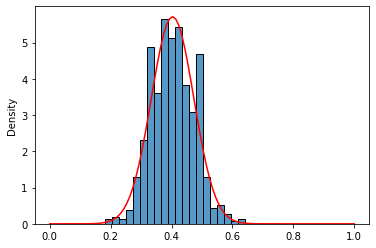

In [56]:
# as the number of samples increases, the variance decreases and the distribution looks more normal
n = 50
trials = 1000
theta_hats = np.zeros(trials)
for t in range(trials):
    try:
        theta_hats[t] = coin.sample(n=n, weights='prob', replace=True).groupby('side').size()['heads'] / n
    except:
        theta_hats[t] = 0

sns.histplot(theta_hats, bins=20, stat='density')

# plot a normal distribution with the same mean and variance
x = np.linspace(0, 1, 100)
y = stats.norm.pdf(x, loc=theta_hats.mean(), scale=np.sqrt(theta_hats.var()))
plt.plot(x, y, color='red')

In [ ]:
# plot a figure to define the z score of a standard normal distribution
x = np.linspace(-5, 5, 100)
y = stats.norm.pdf(x)
plt.plot(x, y)
plt.fill_between(x, y, where=(x > -1.96) & (x < 1.96), color='red', alpha=0.5)
plt.xlabel('z score')

In [60]:
# the interval (-1.96, 1.96) contains 95% of the probability mass of the standard normal distribution
stats.norm.cdf(1.96) - stats.norm.cdf(-1.96)

0.950004209703559

In [63]:
# can get other confidence levels (1-alpha) using the inverse cdf
alpha = .1
stats.norm.ppf(alpha/2), stats.norm.ppf(1-alpha/2)

(-1.6448536269514729, 1.6448536269514722)

Text(-0.5, 0.2, '0.95 CI')

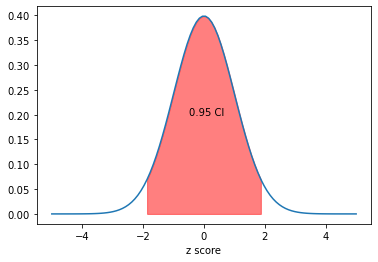

In [76]:
# the interval [-1.96, 1.96] contains 95% of the area under the standard normal curve
alpha = .05
x = np.linspace(-5, 5, 100)
y = stats.norm.pdf(x)
plt.plot(x, y)
plt.fill_between(x, y, where=(x > stats.norm.ppf(alpha/2)) & (x < stats.norm.ppf(1-alpha/2)), color='red', alpha=0.5)
plt.xlabel('z score')
# label the red region as the (1-alpha) confidence interval
plt.text(-.5, 0.2, f'{1-alpha} CI', color='black')

# Confidence intervals

In [8]:
# confidence interval for a single sample 
samples = coin.sample(n=n, weights='prob', replace=True)
theta_hat = samples.groupby('side').size()['heads'] / n
se_hat = np.sqrt(theta_hat * (1 - theta_hat) / n)
print("95% confidence interval:", stats.norm.interval(0.95, loc=theta_hat, scale=se_hat))

95% confidence interval: (0.015974234910674623, 0.5840257650893254)


In [24]:
# of course, for each sample, 
# we would compute the standard error of the estimate
# and use this to compute a confidence interval
# here we use a 95% confidence interval
intervals = pd.DataFrame({'theta_hat': theta_hats}).sort_values('theta_hat')

intervals['se'] = np.sqrt(intervals['theta_hat'] * (1 - intervals['theta_hat']) / n)
intervals['lower'] = intervals['theta_hat'] - 1.96 * intervals['se']
intervals['upper'] = intervals['theta_hat'] + 1.96 * intervals['se']

# how many of the intervals contain the true value of theta?
intervals['trap theta'] = (intervals['lower'] < theta) & (intervals['upper'] > theta)
intervals['trap theta'].mean()

0.906

Text(0, 0.5, 'theta_hat')

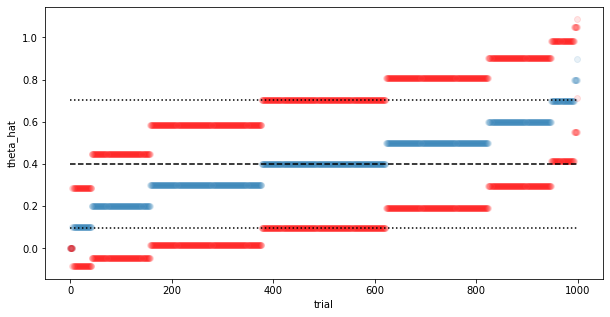

In [43]:
plt.figure(figsize=(10, 5))
plt.plot([0, T], [theta, theta], 'k--')
plt.plot([0, T], [theta - 1.96 * np.sqrt(theta * (1 - theta) / n), theta - 1.96 * np.sqrt(theta * (1 - theta) / n)], 'k:')
plt.plot([0, T], [theta + 1.96 * np.sqrt(theta * (1 - theta) / n), theta + 1.96 * np.sqrt(theta * (1 - theta) / n)], 'k:')
plt.scatter(range(trials), intervals['theta_hat'], marker='o', alpha = .1)
plt.scatter(range(trials), intervals['lower'], color='red', marker='o', alpha = .1)
plt.scatter(range(trials), intervals['upper'], color='red', marker='o', alpha = .1)
plt.xlabel('trial')
plt.ylabel('theta_hat')

Question: why do the estimates for theta cluster at a discrete set of levels?

In [13]:
# compare the 95% interquantile interval for theta_hat to the 95% confidence interval for theta_hat
intervals['theta_hat'].quantile(0.025), intervals['theta_hat'].quantile(0.975)


(0.1, 0.7)